In [1]:
from ape import networks
import matplotlib.pyplot as plt
import math

from typing import List, Optional, ClassVar
import random
import numpy as np
import pickle
import os

import json

from pydantic import StrictInt, field_validator, Field
from pydantic.dataclasses import dataclass
from dataclasses import fields

In [2]:
def json_serializable(cls):
    """Decorator to make a dataclass JSON serializable."""

    def to_dict(self):
        def convert_value(obj):
            # If object has its own to_dict method, use that
            if hasattr(obj, "to_dict"):
                return obj.to_dict()
            # If it's a list/tuple, recursively convert its elements
            elif isinstance(obj, (list, tuple)):
                return [convert_value(x) for x in obj]
            # If it's a dict, recursively convert its values
            elif isinstance(obj, dict):
                return {k: convert_value(v) for k, v in obj.items()}
            # Otherwise return the value as-is
            return obj

        # Convert each field using our custom converter
        return {
            field.name: convert_value(getattr(self, field.name))
            for field in fields(self)
        }

    # Add the to_dict method to the dataclass
    cls.to_dict = to_dict
    return cls

In [3]:
def bounded_int(min_value: int, max_value: int):
    """Decorator for creating bounded integer types with validation"""

    def decorator(cls):
        @dataclass
        class BoundedInt:
            value: StrictInt

            @field_validator("value")
            def check_range(cls, v):
                if not (min_value <= v < max_value):
                    raise ValueError(
                        f"Value {v} not between {min_value} and {max_value - 1}"
                    )
                return v

            def to_dict(self) -> int:
                # Custom serialization to return just the integer value
                return self.value

            def __eq__(self, other):
                if isinstance(other, BoundedInt):
                    return self.value == other.value
                return False

            def __ne__(self, other):
                return not self.__eq__(other)

            def __gt__(self, other):
                return self.value > other.value

            def __ge__(self, other):
                return self.value >= other.value

            def __lt__(self, other):
                return self.value < other.value

            def __le__(self, other):
                return self.value <= other.value

            def __abs__(self):
                return BoundedInt(value=abs(self.value))

            def __neg__(self):
                return BoundedInt(value=-self.value)

            def __add__(self, other):
                if isinstance(other, BoundedInt):
                    result = self.value + other.value
                    if result >= max_value:
                        raise OverflowError("Integer overflow")
                    return BoundedInt(value=result)
                else:
                    raise TypeError(
                        f"Unsupported operand type for +: '{cls.__name__}' and '{type(other)}'"
                    )

            def __sub__(self, other):
                if isinstance(other, BoundedInt):
                    result = self.value - other.value
                    if result < min_value:
                        raise ValueError("Integer underflow")
                    return BoundedInt(value=result)
                else:
                    raise TypeError(
                        f"Unsupported operand type for -: '{cls.__name__}' and '{type(other)}'"
                    )

            def __mul__(self, other):
                if isinstance(other, BoundedInt):
                    result = self.value * other.value
                    if result >= max_value:
                        raise OverflowError("Integer overflow")
                    return BoundedInt(value=result)
                else:
                    raise TypeError(
                        f"Unsupported operand type for *: '{cls.__name__}' and '{type(other)}'"
                    )

            def __truediv__(self, other):
                if isinstance(other, BoundedInt):
                    if other.value == 0:
                        raise ZeroDivisionError("Division by zero")
                    return BoundedInt(value=self.value // other.value)
                else:
                    raise TypeError(
                        f"Unsupported operand type for /: '{cls.__name__}' and '{type(other)}'"
                    )

        # Copy the class name and update annotations
        BoundedInt.__name__ = cls.__name__
        BoundedInt.__qualname__ = cls.__qualname__
        return BoundedInt

    return decorator


UINT256_MAX = 2**256


@bounded_int(min_value=0, max_value=UINT256_MAX)
class Uint256:
    pass


INT_256_MAX = 2**255


@bounded_int(min_value=-INT_256_MAX, max_value=INT_256_MAX)
class Int256:
    pass


a = Uint256(500)

In [4]:
MIN_BASE_FEE_PER_BLOB_GAS = Uint256(1)
BLOB_BASE_FEE_UPDATE_FRACTION = Uint256(3338477)
BLOB_SIZE_IN_FIELDS = Uint256(4096)
GAS_PER_BLOB = Uint256(2**17)


# factor * e ** (numerator / denominator)
def fake_exponential(
    factor: Uint256, numerator: Uint256, denominator: Uint256
) -> Uint256:
    i = Uint256(1)
    output = Uint256(0)
    numerator_accum = factor * denominator
    while numerator_accum > Uint256(0):
        output += numerator_accum
        numerator_accum = (numerator_accum * numerator) / (denominator * i)
        i += Uint256(1)
    return output / denominator

In [5]:
a = Uint256(5415357955)
b = Uint256(2611772262)
c = Uint256(100000000000)

fake_exponential(a, b, c)

Uint256(value=5558657961)

# Collecting data

In the following section we will be collecting data from an Etheruem node. If it is the same range as we last collected we will simply load it from a pickle file.

Note that we only keep track of minimal information related to the L1 block.


In [6]:
@dataclass
class L1BlockSub:
    number: int
    blob_fee: int
    base_fee: int
    excess_blob_gas: int


def get_l1_block_sub(block_number: int) -> L1BlockSub:
    block = networks.provider.web3.eth.get_block(block_number)
    blob_fee = fake_exponential(
        MIN_BASE_FEE_PER_BLOB_GAS, block.excessBlobGas, BLOB_BASE_FEE_UPDATE_FRACTION
    )
    return L1BlockSub(
        number=block.number,
        blob_fee=blob_fee,
        base_fee=block.baseFeePerGas,
        excess_blob_gas=block.excessBlobGas,
    )


def get_blocks(start_number: int, number_of_blocks: int):
    if os.path.exists("blocks.pkl"):
        with open("blocks.pkl", "rb") as f:
            candidated_blocks = pickle.load(f)
            if (
                candidated_blocks[0].number == start_number
                and candidated_blocks[-1].number == start_number + number_of_blocks
            ):
                return candidated_blocks
    networks.parse_network_choice("ethereum:mainnet:node").__enter__()
    blocks = [
        get_l1_block_sub(i)
        for i in range(start_number, start_number + number_of_blocks + 1)
    ]
    with open("blocks.pkl", "wb") as f:
        pickle.dump(blocks, f)
    return blocks


# You should not change these unless you have access to the endpoint in the `ape-config.yaml` file.
# This is because we are using the `ape` library to fetch the data from the Ethereum node, or just
# fetching the data from a pickle file otherwise if we already have it.

block_start_number = 20973664 - 500
blocks_to_pull = 2000

blocks = get_blocks(block_start_number, blocks_to_pull)

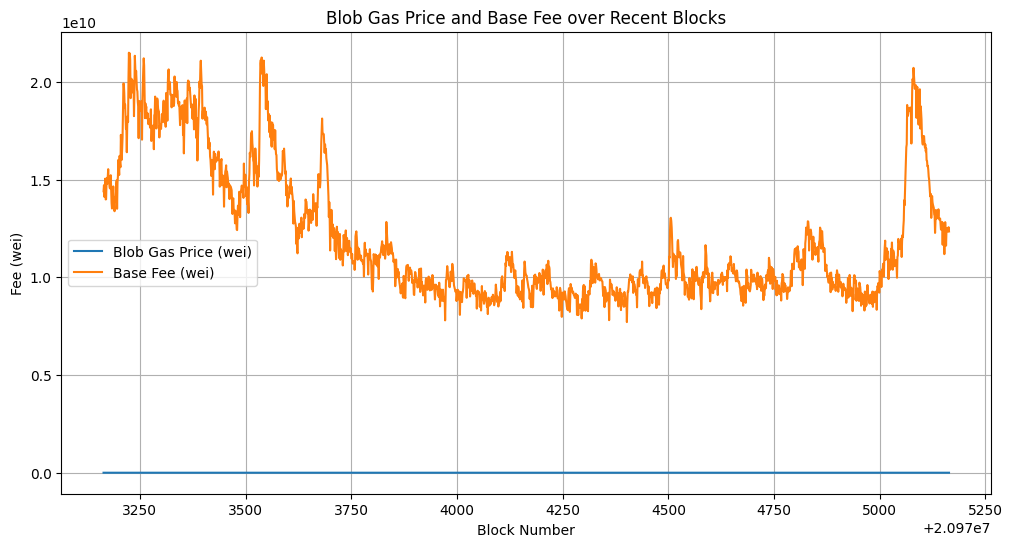

In [7]:
block_numbers = [b.number for b in blocks]
blob_fees = [b.blob_fee for b in blocks]
base_fees = [b.base_fee for b in blocks]

plt.figure(figsize=(12, 6))
plt.plot(block_numbers, blob_fees, label="Blob Gas Price (wei)")
plt.plot(block_numbers, base_fees, label="Base Fee (wei)")
plt.xlabel("Block Number")
plt.ylabel("Fee (wei)")
plt.title("Blob Gas Price and Base Fee over Recent Blocks")
plt.legend()
plt.grid(True)

# Model

We want a model where the `mana` that a transaction requires is **constant** and independent of the l1 cost, but with the base fee fluctuating.  
This is slightly different from the previously specified model, where the `mana` amount itself could also fluctuate, but it is simpler for the users if we have a fixed amount.  
Also it will avoid landing in an issue where your tx is now out of gas because the l1 cost increased.


In [8]:
@dataclass
class Tx:
    mana_spent: Uint256

    nullifiers: Uint256 = Field(default_factory=lambda: Uint256(1))
    notes: Uint256 = Field(default_factory=lambda: Uint256(0))
    public_state_diffs: Uint256 = Field(default_factory=lambda: Uint256(1 + 2 + 2 + 2))
    encrypted_logs_size: Uint256 = Field(default_factory=lambda: Uint256(256))

    def size_in_bytes(self) -> Uint256:
        return (
            Uint256(32) * self.nullifiers
            + Uint256(64) * self.public_state_diffs
            + self.notes * (Uint256(32) + self.encrypted_logs_size)
        )

    def size_in_fields(self) -> Uint256:
        return Uint256(math.ceil(self.size_in_bytes().value / 32))


@dataclass
class Block:
    txs: list[Tx]

    def size_in_fields(self) -> Uint256:
        return sum(tx.size_in_fields() for tx in self.txs)

    def mana_spent(self) -> Uint256:
        return sum((tx.mana_spent for tx in self.txs), start=Uint256(0))

    def blobs_needed(self) -> Uint256:
        # Note that we cast this slightly different as we want the ceiling of the division
        return Uint256(math.ceil(self.size_in_fields().value * 32 / 4096))


@json_serializable
@dataclass
class L1Fees:
    blob_fee: Uint256
    base_fee: Uint256

In [9]:
@json_serializable
@dataclass
class Header:
    excess_mana: Uint256 = Field(default_factory=lambda: Uint256(0))
    mana_used: Uint256 = Field(default_factory=lambda: Uint256(0))
    proving_cost_per_mana_numerator: Uint256 = Field(default_factory=lambda: Uint256(0))
    fee_asset_price_numerator: Uint256 = Field(default_factory=lambda: Uint256(0))


@json_serializable
@dataclass
class ManaBaseFeeComponents:
    data_cost: Uint256
    gas_cost: Uint256
    proving_cost: Uint256
    congestion_cost: Uint256
    congestion_multiplier: Uint256


@json_serializable
@dataclass
class OracleInput:
    proving_cost_modifier: Int256
    fee_asset_price_modifier: Int256


@dataclass
class FeeModel:
    """
    The fee model here will not be perfect, it does not take into account for example that there might be slots with no txs, in reality
    it should be possible for the model, to take this into account mainly impact the `calc_excess_mana` function.
    """

    AZTEC_EPOCH_DURATION = Uint256(32)
    MAX_PROVING_COST_MODIFIER = Int256(int(1e9))
    MAX_FEE_ASSET_PRICE_MODIFIER = Int256(int(1e9))
    CONGESTION_MULTIPLIER_DIVISOR = Uint256(int(1e9))

    mana_target: Uint256
    l1_gas_per_block_proposed: Uint256
    l1_gas_per_epoch_verified: Uint256
    minimum_proving_cost_per_mana: Uint256
    minimum_fee_asset_price: Uint256

    headers: List[Header] = Field(default_factory=lambda: [Header()])

    def fee_update_fraction(self) -> Uint256:
        """
        A bit of magic for the fake exponential and integer math. Computing the divisor this way should ensure
        that the multiplier will increase by at most a factor of ~ 1.125 every block.
        """
        return Uint256(int(self.mana_target.value / 0.117))

    def proving_update_fraction(self) -> Uint256:
        return Uint256(FeeModel.MAX_PROVING_COST_MODIFIER.value * int(100))

    def fee_asset_price_update_fraction(self) -> Uint256:
        return Uint256(FeeModel.MAX_FEE_ASSET_PRICE_MODIFIER.value * int(100))

    def execution_cost(self, l1_fees: L1Fees, block: Optional[Block]) -> Uint256:
        """
        Return the cost of execution in wei.
        Note that it does NOT take into account the priority fee of the tx. This is on purpose, since it could otherwise
        lead to some weird incentives, as a sequencer could otherwise increase the user fees by paying a higher priority fee.
        """
        return (
            self.l1_gas_per_block_proposed
            + (block.blobs_needed() if block else Uint256(3)) * Uint256(50_000)
            + self.l1_gas_per_epoch_verified / FeeModel.AZTEC_EPOCH_DURATION
        ) * l1_fees.base_fee

    def data_cost(self, l1_fees: L1Fees, block: Optional[Block], real=False) -> Uint256:
        """
        Return the cost of data publication in wei
        """
        blob_gas = (
            (block.blobs_needed() if block else Uint256(3)) * Uint256(2**17)
            if real
            else (block.size_in_fields() if block else Uint256(1)) * Uint256(32)
        )
        return blob_gas * l1_fees.blob_fee

    def proving_cost_per_mana(self) -> Uint256:
        return fake_exponential(
            self.minimum_proving_cost_per_mana,
            self.headers[-1].proving_cost_per_mana_numerator,
            self.proving_update_fraction(),
        )

    def fee_asset_price(self) -> Uint256:
        """
        @TODO write up a proper explanation for this.
        Essentially the amount of fee asset per ether gwei. Uses 1e9 in precision.
        A value > 1e9 means that the fee asset is cheaper than ETH
        A value < 1e9 means that the fee asset is more expensive than ETH
        A value = 1e9 means that the fee asset is the same as ETH
        """
        return fake_exponential(
            self.minimum_fee_asset_price,
            self.headers[-1].fee_asset_price_numerator,
            self.fee_asset_price_update_fraction(),
        )

    def mana_base_fee_components(
        self, l1_fees: L1Fees, block: Optional[Block], in_fee_asset: bool = False
    ) -> ManaBaseFeeComponents:
        data_cost = self.data_cost(l1_fees, block, real=True) / self.mana_target
        gas_cost = self.execution_cost(l1_fees, block) / self.mana_target
        proving_cost = self.proving_cost_per_mana()
        congestion_multiplier = fake_exponential(
            Uint256(int(1e9)), self.calc_excess_mana(), self.fee_update_fraction()
        )

        total = data_cost + gas_cost + proving_cost

        congestion_cost = (
            total * congestion_multiplier / FeeModel.CONGESTION_MULTIPLIER_DIVISOR
        ) - total

        # With precision of 1e9
        precision = Uint256(int(1e9))
        fee_asset_price = self.fee_asset_price() if in_fee_asset else precision

        return ManaBaseFeeComponents(
            data_cost=data_cost * fee_asset_price / precision,
            gas_cost=gas_cost * fee_asset_price / precision,
            proving_cost=proving_cost * fee_asset_price / precision,
            congestion_cost=congestion_cost * fee_asset_price / precision,
            congestion_multiplier=congestion_multiplier,
        )

    def mana_base_fee(
        self,
        l1_fees: L1Fees,
        block: Optional[Block],
        apply_congestion_multiplier=False,
        in_fee_asset: bool = False,
    ) -> Uint256:
        """
        Return the base fee of mana in wei.
        We assume that there is a minimum amount of mana spent per block, to the sequencer to manipulate the fee completely.
        """
        components = self.mana_base_fee_components(l1_fees, block, in_fee_asset)

        if apply_congestion_multiplier:
            return (
                components.data_cost
                + components.gas_cost
                + components.proving_cost
                + components.congestion_cost
            )
        return components.data_cost + components.gas_cost + components.proving_cost

    def calc_excess_mana(self) -> Uint256:
        """
        Calculate the excess mana in the last block.
        Should be updated to take into account that there might be slots with no txs.
        """
        spent = self.headers[-1].mana_used
        excess = self.headers[-1].excess_mana
        if excess + spent < self.mana_target:
            return Uint256(0)
        return excess + spent - self.mana_target

    def add_slot(
        self, block: Optional[Block], oracle_input: Optional[OracleInput] = None
    ):
        """
        Potentially add a block for a slot, if there is one.
        """
        assert block is None or block.mana_spent() <= self.mana_target * Uint256(
            2
        ), "invalid block size"

        proving_cost_modifier = (
            oracle_input.proving_cost_modifier if oracle_input else Int256(0)
        )
        assert proving_cost_modifier is None or (
            abs(proving_cost_modifier) <= FeeModel.MAX_PROVING_COST_MODIFIER
        ), "invalid proving modifier"

        fee_asset_price_modifier = (
            oracle_input.fee_asset_price_modifier if oracle_input else Int256(0)
        )
        assert fee_asset_price_modifier is None or (
            abs(fee_asset_price_modifier) <= FeeModel.MAX_FEE_ASSET_PRICE_MODIFIER
        ), "invalid fee asset price modifier"

        new_header = Header(
            excess_mana=self.calc_excess_mana(),
            mana_used=block.mana_spent() if block else Uint256(0),
            proving_cost_per_mana_numerator=Uint256(
                max(
                    proving_cost_modifier.value
                    + self.headers[-1].proving_cost_per_mana_numerator.value,
                    0,
                )
            ),
            fee_asset_price_numerator=Uint256(
                max(
                    fee_asset_price_modifier.value
                    + self.headers[-1].fee_asset_price_numerator.value,
                    0,
                )
            ),
        )
        self.headers.append(new_header)

## Simulating some blocks

In the following, we will be simulating a bunch of blocks and then plotting our results.

For the simulation of a block, we will be generating a random block, with mana spent being a random number between 0 and 2 \* mana_target.  
We will keep collecting transactions from a "randomized" mempool until we have either reached the mana target, or the mempool size limit.  
We only collect transactions find the fee acceptable (another sampling) and don't force us beyond the limit.  
The size of the transactions are also drawn from a distribution.


> This is probably the place where it would make good sense to get someone that know thier stuff in.  
> We have a setup that could work, but at the same time, it does not seem to work perfectly well.


In [10]:
USD_PER_ETH = 2638
USD_PER_WEI = USD_PER_ETH / 1e18
MANA_PER_BASE_TX = Uint256(21000)
USD_PER_BASE_TX = 0.3  # 0.3 is the real value, this is me messing around # a value kinda pulled out the ass as of now, expecting big reductions

USD_PER_MANA = USD_PER_BASE_TX / MANA_PER_BASE_TX.value

WEI_PER_MANA = USD_PER_MANA / USD_PER_WEI

print(f"WEI PER MANA: {WEI_PER_MANA:.2f}")
print(f"GWEI PER MANA / 1e9: {WEI_PER_MANA / 1e9:.2f} gwei")

print(f"The cost: {2638 * MANA_PER_BASE_TX.value * WEI_PER_MANA / 1e18:.2f} USD")

WEI PER MANA: 5415357955.16
GWEI PER MANA / 1e9: 5.42 gwei
The cost: 0.30 USD


In [11]:
@json_serializable
@dataclass
class TestPointOutputs:
    fee_asset_price_at_execution: Uint256
    mana_base_fee_components_in_wei: ManaBaseFeeComponents
    mana_base_fee_components_in_fee_asset: ManaBaseFeeComponents


@json_serializable
@dataclass
class TestPoint:
    l1_block_number: Uint256
    l1_fees: L1Fees
    parent_header: Header
    header: Header
    oracle_input: OracleInput
    outputs: TestPointOutputs

In [12]:
fee_model = FeeModel(
    mana_target=Uint256(int(1e8)),
    l1_gas_per_block_proposed=Uint256(int(0.15e6)),
    l1_gas_per_epoch_verified=Uint256(int(1e6)),
    minimum_proving_cost_per_mana=Uint256(int(WEI_PER_MANA)),
    minimum_fee_asset_price=Uint256(int(10e9)),
)


def generate_random_with_min(
    mean: Uint256, std_dev: Uint256, min_value: Uint256
) -> Uint256:
    while True:
        value = int(random.gauss(mean.value, std_dev.value))
        if value >= min_value.value:
            return Uint256(value)


AZTEC_SLOT_DURATION = 3
MEMPOOL_SIZE = 5000


aztec_l1_block_numbers = []
l1_base_fees = []

l2_blocks = []

costs = []
costs_fee_asset = []

test_points = []

for i in range(len(blob_fees)):
    l1_fees = L1Fees(blob_fee=Uint256(blob_fees[i]), base_fee=Uint256(base_fees[i]))
    l1_base_fees.append(l1_fees.base_fee)

    if i % AZTEC_SLOT_DURATION == 0:
        cost = fee_model.mana_base_fee_components(l1_fees, None)
        costs.append(cost)
        costs_fee_asset.append(
            fee_model.mana_base_fee_components(l1_fees, None, in_fee_asset=True)
        )

        real_cost = cost.data_cost + cost.gas_cost + cost.proving_cost
        mana_base_fee = real_cost + cost.congestion_cost

        mana_spent_block = Uint256(0)
        mana_planned_for_block = min(
            generate_random_with_min(
                fee_model.mana_target,
                fee_model.mana_target,
                Uint256(0),
            ),
            fee_model.mana_target * Uint256(2),
        )

        txs = []
        count = 0

        while (
            abs(mana_planned_for_block.value - mana_spent_block.value)
            >= MANA_PER_BASE_TX.value
            and count < MEMPOOL_SIZE
        ):
            count += 1
            mana_spent_tx = generate_random_with_min(
                MANA_PER_BASE_TX * Uint256(2), Uint256(500_000), MANA_PER_BASE_TX
            )
            within_bounds = (
                mana_spent_tx + mana_spent_block <= fee_model.mana_target * Uint256(2)
            )
            acceptable_mana_base_fee = generate_random_with_min(
                real_cost, Uint256(2) * real_cost, Uint256(0)
            )

            is_fee_acceptable = acceptable_mana_base_fee >= mana_base_fee

            if within_bounds and is_fee_acceptable:
                txs.append(Tx(mana_spent=mana_spent_tx))
                mana_spent_block += mana_spent_tx

        block = Block(txs=txs)

        ## We need to fix what we got below here

        # Deciding oracle movements. Here we assume that there are some fluctuation in the price of ETH and proving, up to 1% per 36 second.
        oracle_input = OracleInput(
            proving_cost_modifier=Int256(
                int(max(-1, min(1, random.gauss(0, 0.1))) * 1e9)
            ),
            fee_asset_price_modifier=Int256(
                int(max(-1, min(1, random.gauss(0.01, 0.5))) * 1e9)
            ),
        )

        fee_asset_price_at_execution = fee_model.fee_asset_price()
        fee_model.add_slot(block, oracle_input)

        test_points.append(
            TestPoint(
                l1_block_number=Uint256(block_numbers[i]),
                l1_fees=l1_fees,
                header=fee_model.headers[-1],
                parent_header=fee_model.headers[-2],
                oracle_input=oracle_input,
                outputs=TestPointOutputs(
                    fee_asset_price_at_execution=fee_asset_price_at_execution,
                    mana_base_fee_components_in_wei=costs[-1],
                    mana_base_fee_components_in_fee_asset=costs_fee_asset[-1],
                ),
            )
        )

        l2_blocks.append(block)
        aztec_l1_block_numbers.append(block_numbers[i])

### Plotting the results


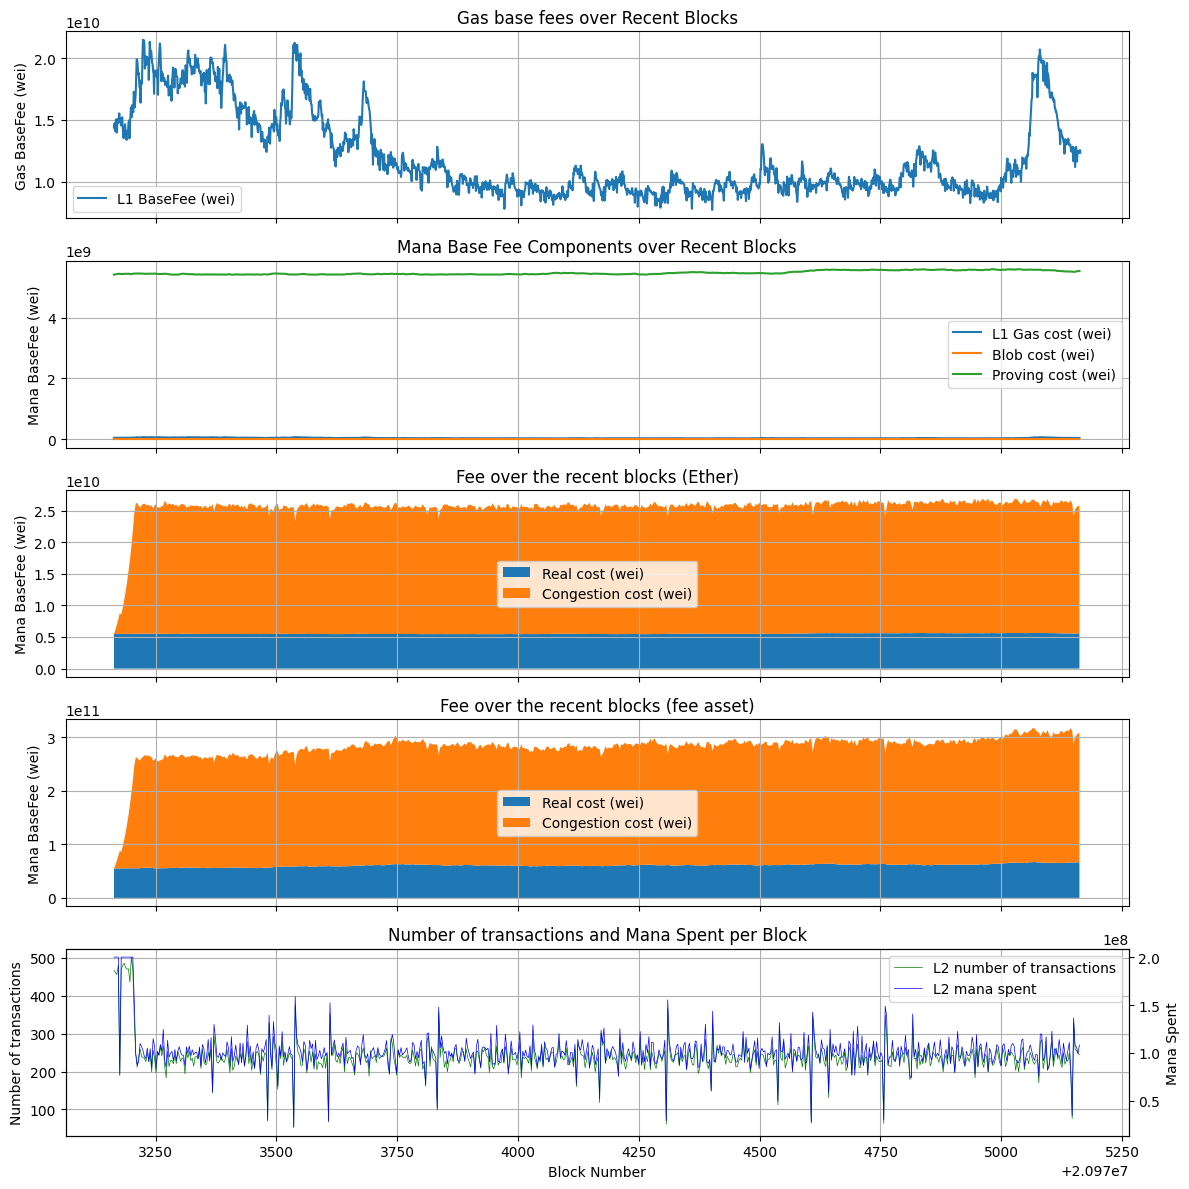

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

ax1.plot(block_numbers, [i.value for i in l1_base_fees], label="L1 BaseFee (wei)")
ax1.set_ylabel("Gas BaseFee (wei)")
ax1.set_title("Gas base fees over Recent Blocks")
ax1.legend()
ax1.grid(True)


l1_gas_costs = [cost.gas_cost.value for cost in costs]
data_costs = [cost.data_cost.value for cost in costs]
proving_costs = [cost.proving_cost.value for cost in costs]
congestion_costs = [cost.congestion_cost.value for cost in costs]


ax2.plot(aztec_l1_block_numbers, l1_gas_costs, label="L1 Gas cost (wei)")
ax2.plot(aztec_l1_block_numbers, data_costs, label="Blob cost (wei)")
ax2.plot(aztec_l1_block_numbers, proving_costs, label="Proving cost (wei)")

ax2.set_ylabel("Mana BaseFee (wei)")
ax2.set_title("Mana Base Fee Components over Recent Blocks")
ax2.legend()
ax2.grid(True)


real_costs = [
    l1_gas_costs[i] + data_costs[i] + proving_costs[i] for i in range(len(l1_gas_costs))
]
total_costs = [real_costs[i] + congestion_costs[i] for i in range(len(l1_gas_costs))]
ax3.fill_between(aztec_l1_block_numbers, 0, real_costs, label="Real cost (wei)")
ax3.fill_between(
    aztec_l1_block_numbers,
    real_costs,
    total_costs,
    label="Congestion cost (wei)",
)
ax3.set_ylabel("Mana BaseFee (wei)")
ax3.set_title("Fee over the recent blocks (Ether)")
ax3.legend()
ax3.grid(True)


real_costs = [
    c.data_cost.value + c.gas_cost.value + c.proving_cost.value for c in costs_fee_asset
]
total_costs = [
    real_costs[i] + costs_fee_asset[i].congestion_cost.value
    for i in range(len(real_costs))
]
ax4.fill_between(aztec_l1_block_numbers, 0, real_costs, label="Real cost (wei)")
ax4.fill_between(
    aztec_l1_block_numbers,
    real_costs,
    total_costs,
    label="Congestion cost (wei)",
)
ax4.set_ylabel("Mana BaseFee (wei)")
ax4.set_title("Fee over the recent blocks (fee asset)")
ax4.legend()
ax4.grid(True)


flem = ax5

t_0 = [len(b.txs) for b in l2_blocks]
t_1 = [b.mana_spent().value for b in l2_blocks]
flem_2 = flem.twinx()
(l1,) = flem.plot(
    aztec_l1_block_numbers,
    t_0,
    label="L2 number of transactions",
    color="green",
    linewidth=0.5,
)
(l2,) = flem_2.plot(
    aztec_l1_block_numbers, t_1, label="L2 mana spent", color="blue", linewidth=0.5
)
flem.set_xlabel("Block Number")
flem.set_ylabel("Number of transactions")
flem_2.set_ylabel("Mana Spent")
flem.set_title("Number of transactions and Mana Spent per Block")
flem.legend([l1, l2], ["L2 number of transactions", "L2 mana spent"])
flem.grid(True)

plt.tight_layout()
plt.show()

## Points of interest

- The multiplier makes the base fee more unstable, it might be better to consider a different function to see if we can stabilize it.


## To test with sol


In [14]:
# Constants for the fee maths!
code = f"""
uint256 internal constant MINIMUM_PROVING_COST_PER_MANA = {fee_model.minimum_proving_cost_per_mana};
uint256 internal constant MAX_PROVING_COST_MODIFIER = {FeeModel.MAX_PROVING_COST_MODIFIER};
uint256 internal constant PROVING_UPDATE_FRACTION = {fee_model.proving_update_fraction()};


uint256 internal constant MINIMUM_FEE_ASSET_PRICE = {fee_model.minimum_fee_asset_price};
uint256 internal constant MAX_FEE_ASSET_PRICE_MODIFIER = {FeeModel.MAX_FEE_ASSET_PRICE_MODIFIER};
uint256 internal constant FEE_ASSET_PRICE_UPDATE_FRACTION = {fee_model.fee_asset_price_update_fraction()};
"""
print(code)

# Create a json object with the test points
v = json.dumps([x.to_dict() for x in test_points])
print(v)


uint256 internal constant MINIMUM_PROVING_COST_PER_MANA = Uint256(value=5415357955);
uint256 internal constant MAX_PROVING_COST_MODIFIER = Int256(value=1000000000);
uint256 internal constant PROVING_UPDATE_FRACTION = Uint256(value=100000000000);


uint256 internal constant MINIMUM_FEE_ASSET_PRICE = Uint256(value=10000000000);
uint256 internal constant MAX_FEE_ASSET_PRICE_MODIFIER = Int256(value=1000000000);
uint256 internal constant FEE_ASSET_PRICE_UPDATE_FRACTION = Uint256(value=100000000000);

[{"l1_block_number": 20973164, "l1_fees": {"blob_fee": 23, "base_fee": 14402849460}, "parent_header": {"excess_mana": 0, "mana_used": 0, "proving_cost_per_mana_numerator": 0, "fee_asset_price_numerator": 0}, "header": {"excess_mana": 0, "mana_used": 199989642, "proving_cost_per_mana_numerator": 177926583, "fee_asset_price_numerator": 46327659}, "oracle_input": {"proving_cost_modifier": 177926583, "fee_asset_price_modifier": 46327659}, "outputs": {"fee_asset_price_at_execution": 10000000000, "m

# Bandwidth

In Etheruem, the bandwidth consumed by a validator as noted in the Eth 2.0 book is ~3.5mb/s.

If we follow the assumption that Ethereum transactions are 700 bytes, and have 15 txs per second, the 180 transaction per block will "require" 0.01mb/s, so there is a good chunk of overhead etc.


In [15]:
ETH_TX_BANDWIDTH = 700
ETH_BLOCK_BANDWIDTH = ETH_TX_BANDWIDTH * 15

ETH_MB_PER_SEC = ETH_BLOCK_BANDWIDTH / 1024 / 1024
print(f"Tx Bandwidth: {ETH_MB_PER_SEC:.2f} MB/s -> {ETH_MB_PER_SEC * 8:.2f} mbit/s")

ETH_FACTOR = 3.5 / ETH_MB_PER_SEC

print(f"ETH_FACTOR: {ETH_FACTOR:.2f}")

Tx Bandwidth: 0.01 MB/s -> 0.08 mbit/s
ETH_FACTOR: 349.53


We call this overhead for the `ETH_FACTOR`. The overhead is due to the gossiping across the nodes, the transactions that might not actually make it, the block headers etc.

We don't expect to have as big of an overhead, for the simple reason that we do not expect to have as many nodes. Nevertheless, it is a good thing to keep in mind when thinking about the bandwidth requirements.


In [16]:
AZTEC_TX_BANDWIDTH = 80 * 1024
AZTEC_BLOCK_BANDWIDTH = AZTEC_TX_BANDWIDTH * 10
AZTEC_MB_PER_SEC = AZTEC_BLOCK_BANDWIDTH / 1024 / 1024
print(f"Bandwidth: {AZTEC_MB_PER_SEC:.2f} MB/s -> {AZTEC_MB_PER_SEC * 8:.2f} mbit/s")

ASSUMED_AZTEC_FACTOR = max(1, ETH_FACTOR / 32)

print(f"ASSUMED_AZTEC_FACTOR: {ASSUMED_AZTEC_FACTOR:.2f}")

print(
    f"Bandwidth with assumed AZTEC_FACTOR: {AZTEC_MB_PER_SEC * 8 * ASSUMED_AZTEC_FACTOR:.2f} mbit/s"
)

Bandwidth: 0.78 MB/s -> 6.25 mbit/s
ASSUMED_AZTEC_FACTOR: 10.92
Bandwidth with assumed AZTEC_FACTOR: 68.27 mbit/s
